In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings

np.random.seed = 42

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer, label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

In [4]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Diabetes_012'])

In [5]:
colors = ['#602CA3', '#FE4680', '#FE9B06']

### Feature engineering

In [6]:
def bin_BMI(data):
    bins = [0, 18.5, 24.9, 29.9, float('inf')]
    labels = ['Underweight', 'Healthy weight', 'Overweight', 'Obesity']
    data['binned_BMI'] = pd.cut(data['BMI'], bins=bins, labels=labels)
    data['binned_BMI'] = data['binned_BMI'].cat.codes
    return data

def calculate_OverallHealthStatus(data):
    weights = {'GenHlth': 0.7, 'MentHlth': 0.01, 'PhysHlth': 0.01}
    weighted_scores = data[['GenHlth', 'MentHlth', 'PhysHlth']] * pd.Series(weights)
    data['OverallHealthStatus'] = weighted_scores.sum(axis=1)
    return data

def calculate_OverallHealthRisk(data):
    weights = {'HighBP': 1.3, 'HighChol': 1, 'Stroke': 0.8, 'HeartDiseaseorAttack': 1.3}
    weighted_scores = data[['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack']] * pd.Series(weights)
    data['OverallHealthRisk'] = weighted_scores.sum(axis=1)
    return data

def calculate_OverallHealthRisk_CDC(data):
    data['OverallHealthRisk_CDC'] = data[['BMI', 'Age', 'PhysActivity']].mean(axis=1)
    return data

def identify_NutritiousFood(data):
    data['NutritiousFood'] = (data['Fruits'].astype(bool) & data['Veggies'].astype(bool)).astype(int)
    return data

def identify_BadHabits(data):
    data['BadHabits'] = (data['Smoker'].astype(bool) & data['HvyAlcoholConsump'].astype(bool)).astype(int)
    return data
    
def deleteRepeated(data):
    data.drop(['GenHlth', 'MentHlth', 'PhysHlth', 'HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'BMI', 'Age', 'PhysActivity', "Fruits", 
               "Veggies", "Smoker", 'HvyAlcoholConsump'], axis=1, inplace=True)
    return data

feature_engineering_pipeline = Pipeline([
    ('bin_BMI', FunctionTransformer(bin_BMI)),
    ('calculate_OverallHealthStatus', FunctionTransformer(calculate_OverallHealthStatus)),
    ('calculate_OverallHealthRisk', FunctionTransformer(calculate_OverallHealthRisk)),
    ('calculate_OverallHealthRisk_CDC', FunctionTransformer(calculate_OverallHealthRisk_CDC)),
    ('identify_NutritiousFood', FunctionTransformer(identify_NutritiousFood)),
    ('identify_BadHabits', FunctionTransformer(identify_BadHabits)),
    ('deleteRepeated', FunctionTransformer(deleteRepeated))
])

In [7]:
X_dev = feature_engineering_pipeline.transform(X_dev)

In [8]:
y = np.array(X_dev['Diabetes_012'])
X = X_dev.drop(['Diabetes_012'],axis=1)

y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = 3

X_train, X_val, y_train, y_val = train_test_split(X, y_bin, test_size=0.33, random_state=0)

In [9]:
def draw_ROC_curve(y_val, y_score, typ_modelu):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curve for each class - ' + typ_modelu)
    plt.legend(loc='lower right')
    plt.show()
    
def AUC_GINI_plot(y_val, y_score, typ_modelu):
    bl = pd.DataFrame(0, index=range(0), columns=range(3))
    bl.columns = ["class", "error", "error_value"]
    j = 0
    
    for i in range(n_classes):
        AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
        gini = 2*AUC - 1
        
        bl.loc[j] = [i, "AUC", AUC]
        j+=1
        bl.loc[j] = [i, "GINI", gini]
        j+=1
    ax = sns.barplot(x= bl["error"], y=bl["error_value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.bar_label(ax.containers[2])
    plt.ylim(0, 1)
    plt.xlabel(None)
    plt.title("Comparison of AUC and GINI for each class - " + typ_modelu)
    plt.show()

## Best Models
After performing tuning, the following models have been recognized as the best:
* Gradient Boosting
* XGBoost classifier
* Multi-layer Perceptron classifier

### Gradient Boosting for classification

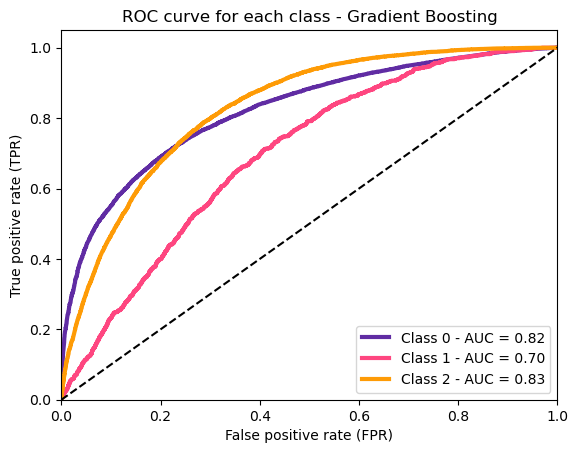

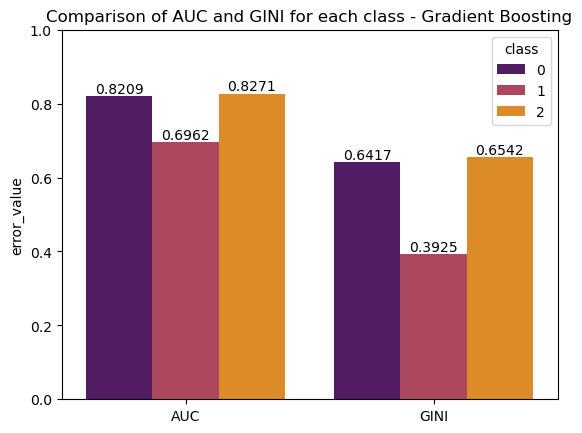

roc_auc_ovr: 0.7814


In [53]:
clf_GBC = GradientBoostingClassifier(n_estimators = 100, min_samples_leaf = 1, max_depth = 3, learning_rate = 0.1)

clf_GBC.fit(X_train, y_train.argmax(axis=1))

y_score = clf_GBC.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Gradient Boosting')

AUC_GINI_plot(y_val, y_score, 'Gradient Boosting')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### XGBoost

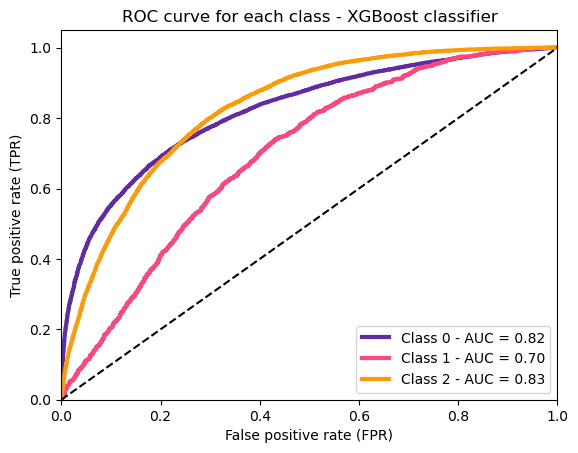

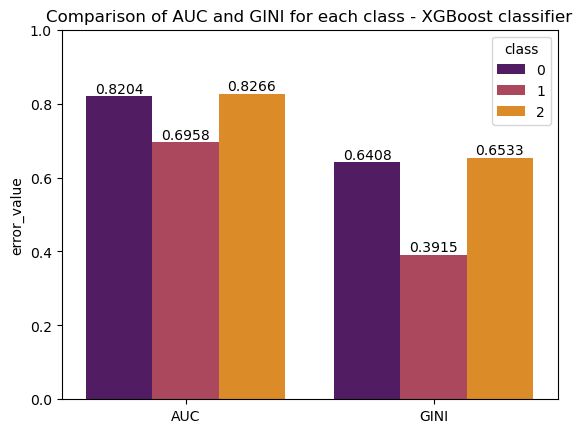

roc_auc_ovr: 0.7809


In [34]:
clf_XGB = XGBClassifier(objective="multi:softprob", learning_rate = 0.1, max_depth = 2, n_estimators = 200)

clf_XGB.fit(X_train, y_train.argmax(axis=1))

y_score = clf_XGB.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'XGBoost classifier')

AUC_GINI_plot(y_val, y_score, 'XGBoost classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### Multi-layer Perceptron classifier

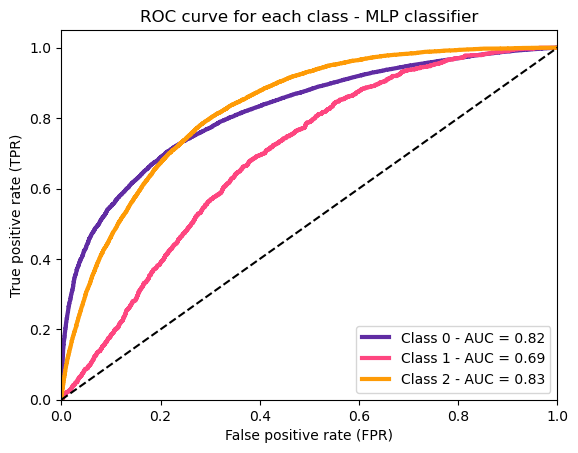

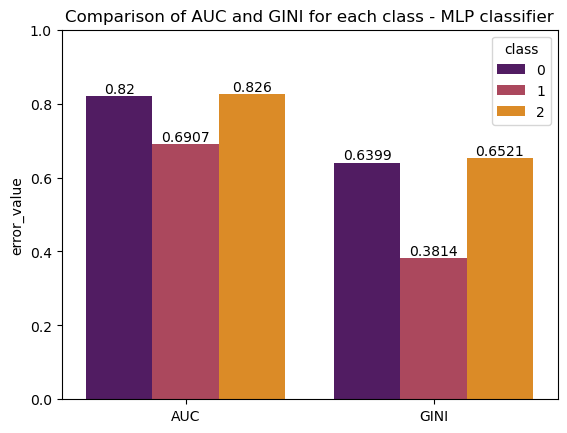

roc_auc_ovr: 0.7789


In [12]:
max_iter=1000, solver = 'lbfgs', learning_rate = 'constant', hidden_layer_sizes = (100, 3), early_stopping = False, 
                    alpha = 0.1, activation = 'logistic'

clf_MLP.fit(X_train, y_train.argmax(axis=1))

y_score = clf_MLP.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'MLP classifier')

AUC_GINI_plot(y_val, y_score, 'MLP classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

In [13]:
# import joblib 

# joblib.dump(clf_GBC, 'clf_GBC.sav')
# joblib.dump(clf_XGB, 'clf_XGB.sav')
# joblib.dump(clf_MLP, 'clf_MLP.sav')

## Final model - XGBoost

According to our business assumption of aiming to build a model that helps detect the highest number of diabetic patients, we ultimately decide on XGBoost

## SHAP for XGBoost

In [35]:
import shap

In [36]:
explainer = shap.TreeExplainer(clf_XGB)  
shap_values = explainer.shap_values(X_train)

In [37]:
shap_values.shape

(118975, 13, 3)

### SHAP summary_plot for NoDiabetes Prediction

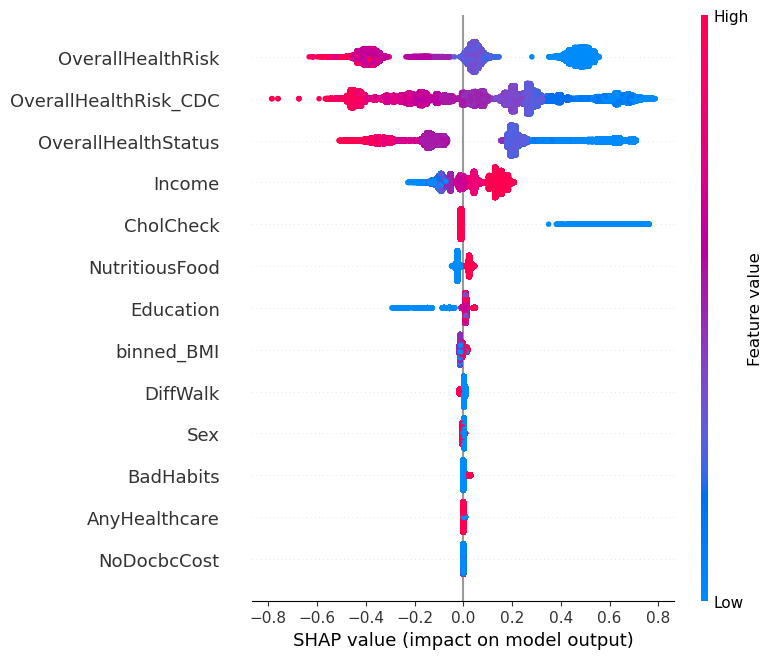

In [38]:
shap.summary_plot(shap_values[:, : , 0], X_train.values, feature_names = X_train.columns)

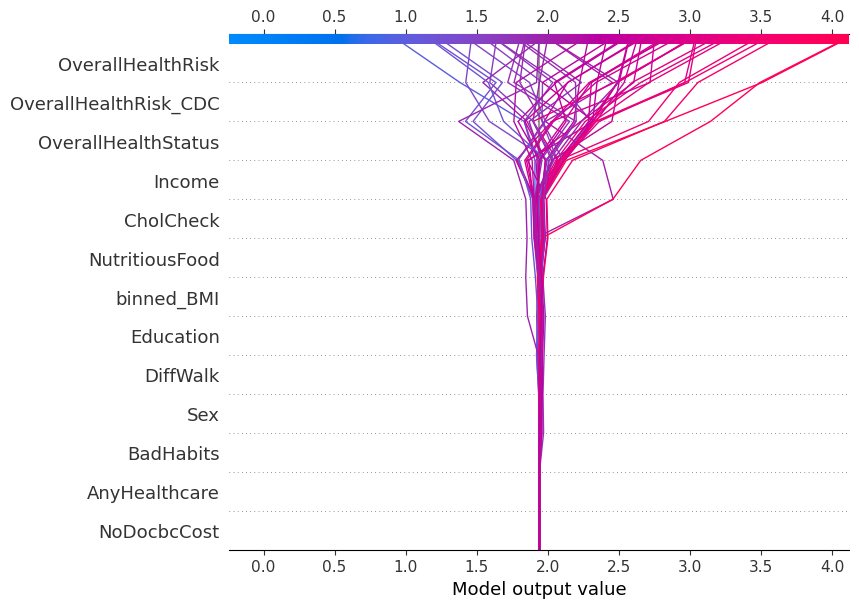

In [39]:
features = X_train.iloc[0:50]
shap.decision_plot(explainer.expected_value[0], shap_values[0:50, :, 0], features)

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0, :, 0], X_train.iloc[0])

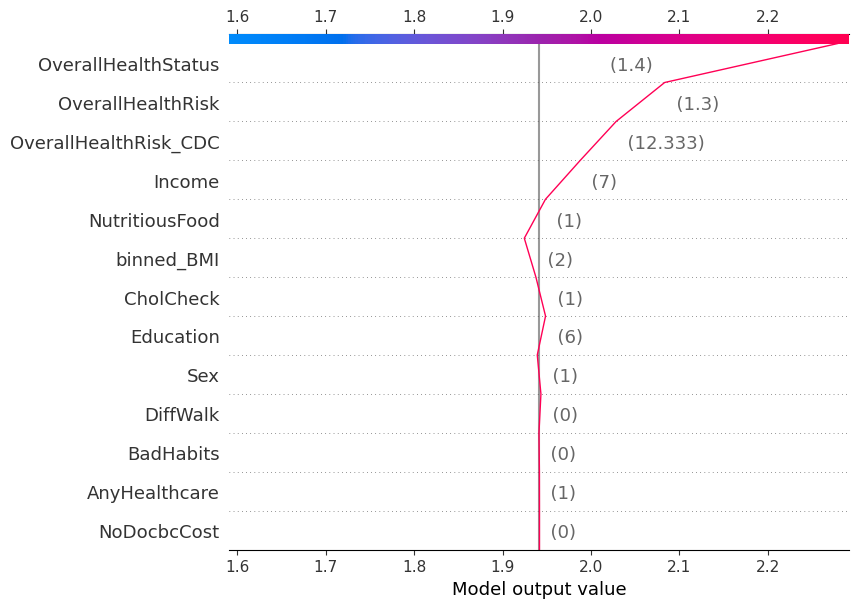

In [41]:
shap.decision_plot(explainer.expected_value[0], shap_values[0, :, 0], X_train.iloc[0])

### SHAP summary_plot for PreDiabetes Prediction

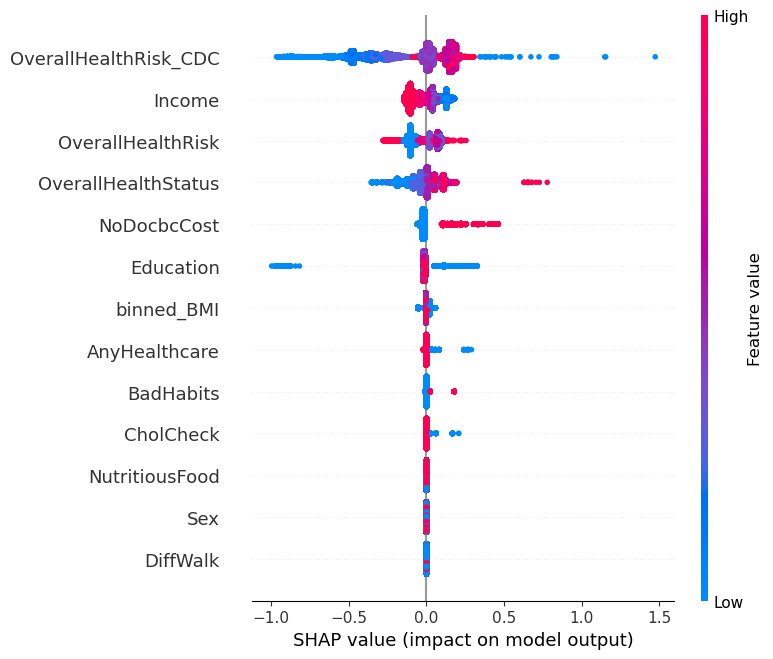

In [42]:
shap.summary_plot(shap_values[:, : , 1], X_train.values, feature_names = X_train.columns)

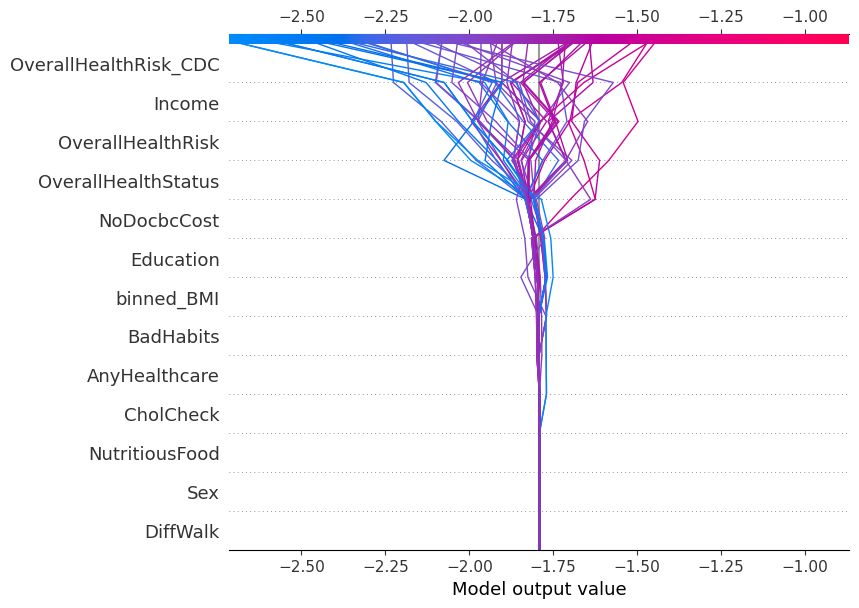

In [43]:
features = X_train.iloc[0:50]
shap.decision_plot(explainer.expected_value[1], shap_values[0:50, :, 1], features)

In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], X_train.iloc[0])

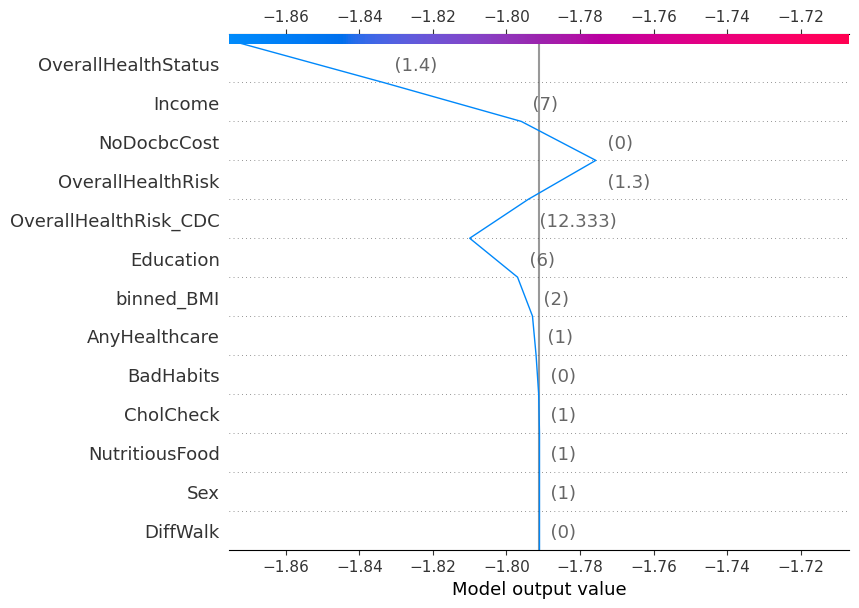

In [45]:
shap.decision_plot(explainer.expected_value[1], shap_values[0, :, 1], X_train.iloc[0])

### SHAP summary_plot for Diabetes Prediction

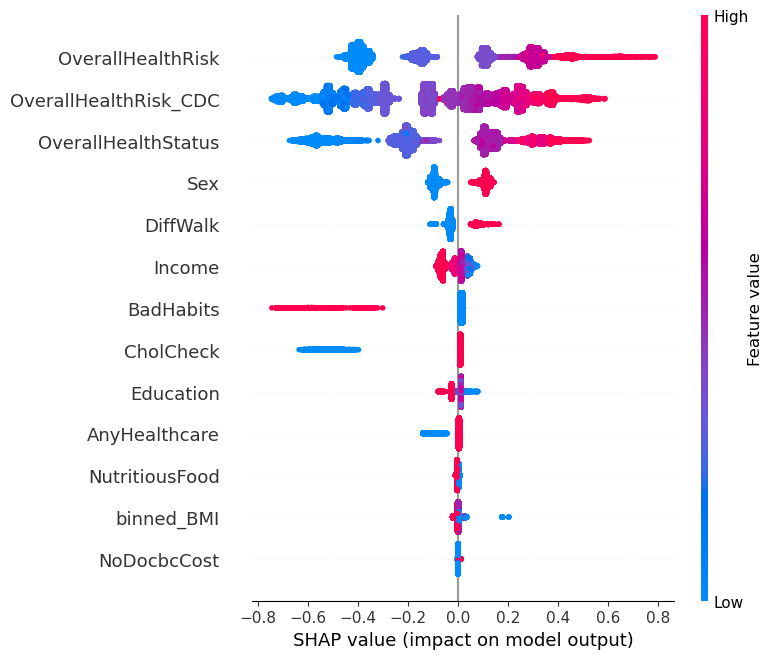

In [46]:
shap.summary_plot(shap_values[:, : , 2], X_train.values, feature_names = X_train.columns)

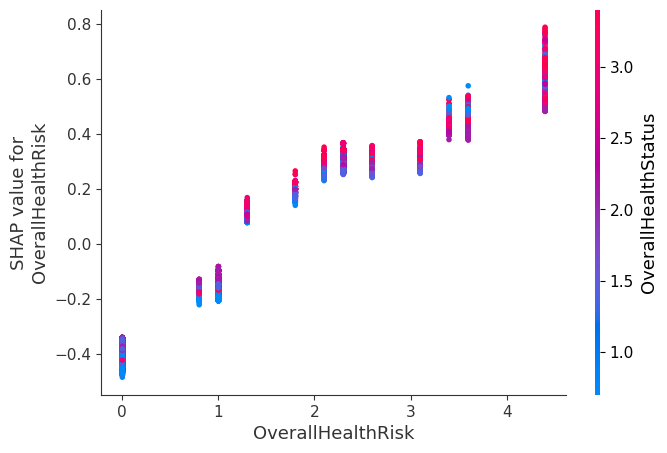

In [47]:
shap.dependence_plot("OverallHealthRisk", shap_values[:, : , 2], X_train)

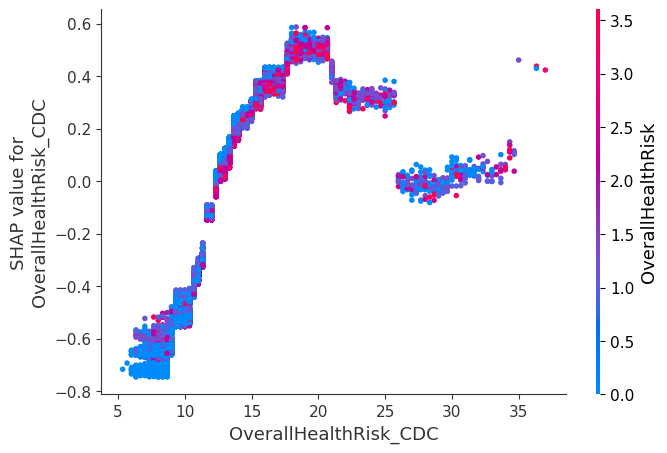

In [48]:
shap.dependence_plot("OverallHealthRisk_CDC", shap_values[:, : , 2], X_train)

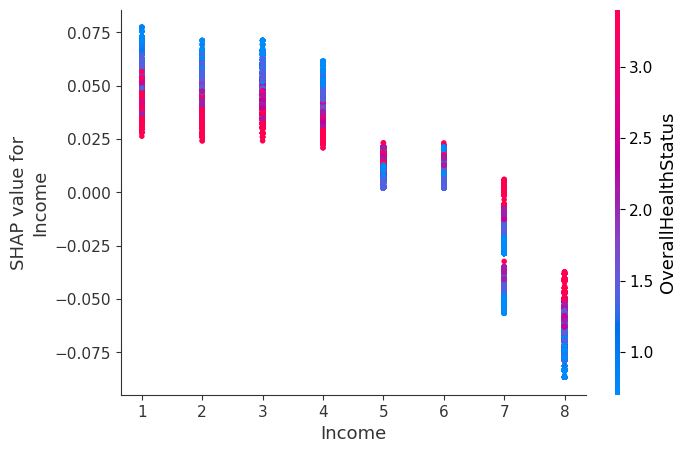

In [49]:
shap.dependence_plot("Income", shap_values[:, : , 2], X_train)

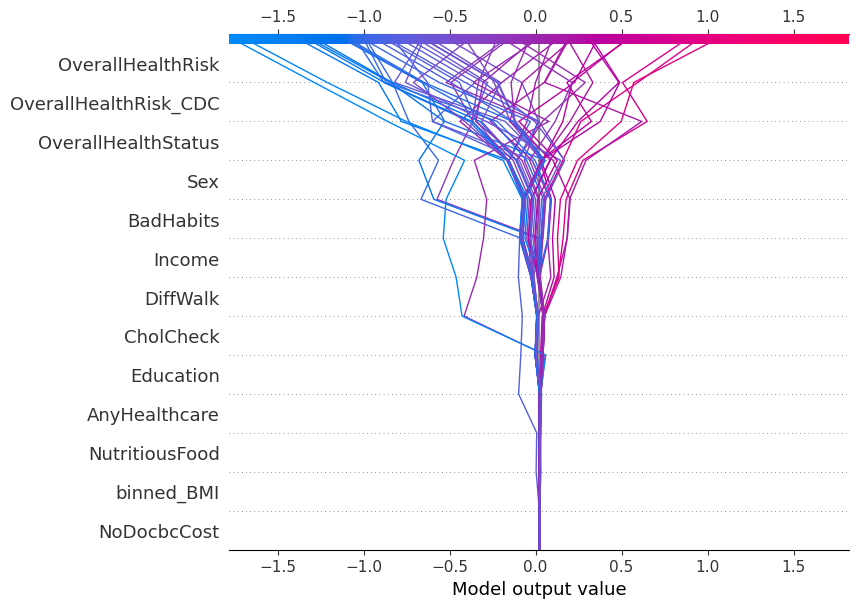

In [50]:
features = X_train.iloc[0:50]
shap.decision_plot(explainer.expected_value[2], shap_values[0:50, :, 2], features)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[0, :, 2], X_train.iloc[0])

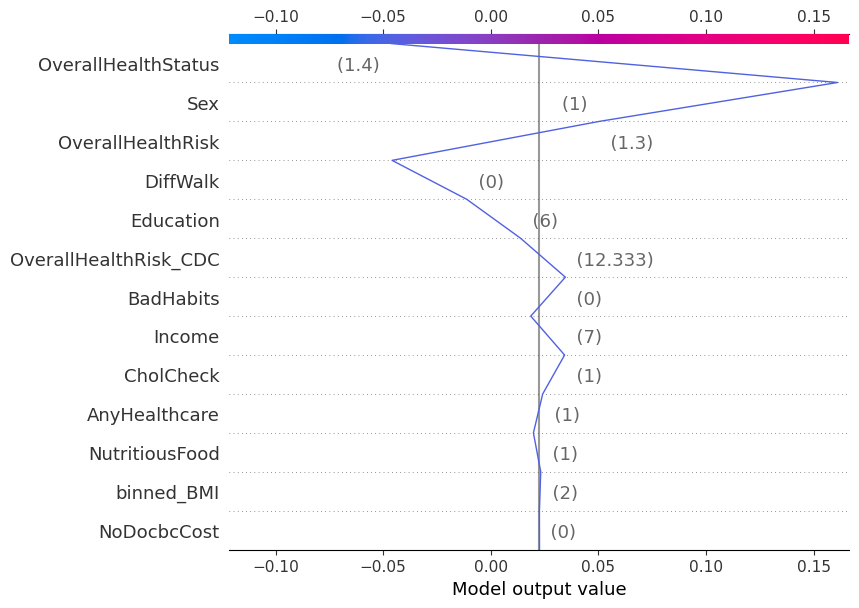

In [52]:
shap.decision_plot(explainer.expected_value[2], shap_values[0, :, 2], X_train.iloc[0])